Here is some simple code in neural network to recognise pictures of horses and humans.

Information about the raw data can be found here.
https://www.tensorflow.org/datasets/datasets#horses_or_humans

In [0]:
%tensorflow_version 2.x
#!pip install tensorflow_probability==0.8.0rc0 --user --upgrade
!pip install -q -U tensorflow_hub
!pip install -q -U tensorflow_datasets

TensorFlow 2.x selected.
     |████████████████████████████████| 2.3MB 2.8MB/s 


In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
# from skimage.transform import resize

import tensorflow as tf
# tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

Instead of working with TensorFlow dataset, we import the raw data as nparray. 

In [0]:
builder = tfds.builder("horses_or_humans")
assert builder.info.splits['train'].num_examples == 1027
assert builder.info.splits['test'].num_examples == 256
builder.download_and_prepare()
datasets = builder.as_dataset()
np_datasets = tfds.as_numpy(datasets)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/1.0.0. Subsequent calls will reuse this data.


In [0]:
n_train = 1027
n_test = 256
n_class = 2

im_res = 300

In [0]:
train_data = np_datasets['train']
test_data = np_datasets['test']

x_train = np.empty((n_train,im_res,im_res,3), dtype=np.int)
y_train = np.empty(n_train, dtype=np.int)

for i, e in enumerate(train_data):
  x_train[i] = e['image']
  y_train[i] = e['label']

x_test = np.empty((n_test,im_res,im_res,3), dtype=np.int)
y_test = np.empty(n_test)

for i, e in enumerate(test_data):
  x_test[i] = e['image']
  y_test[i] = e['label']

*   x_train, an array of dimension (1027, 300, 300, 3), contains 1027 RGB pictures of horses and human with pixel resolution of 300x300.

*   y_train, a 1-d array of 1027, contains the labels for x_train.

*   x_test, an array of dimension (256, 300, 300, 3), contains 256 RGB pictures of horses and human with pixel resolution of 300x300.

*   y_test, a 1-d array of 1027, contains the labels for x_test.

A visualization of the first 100 pictures in the training data.

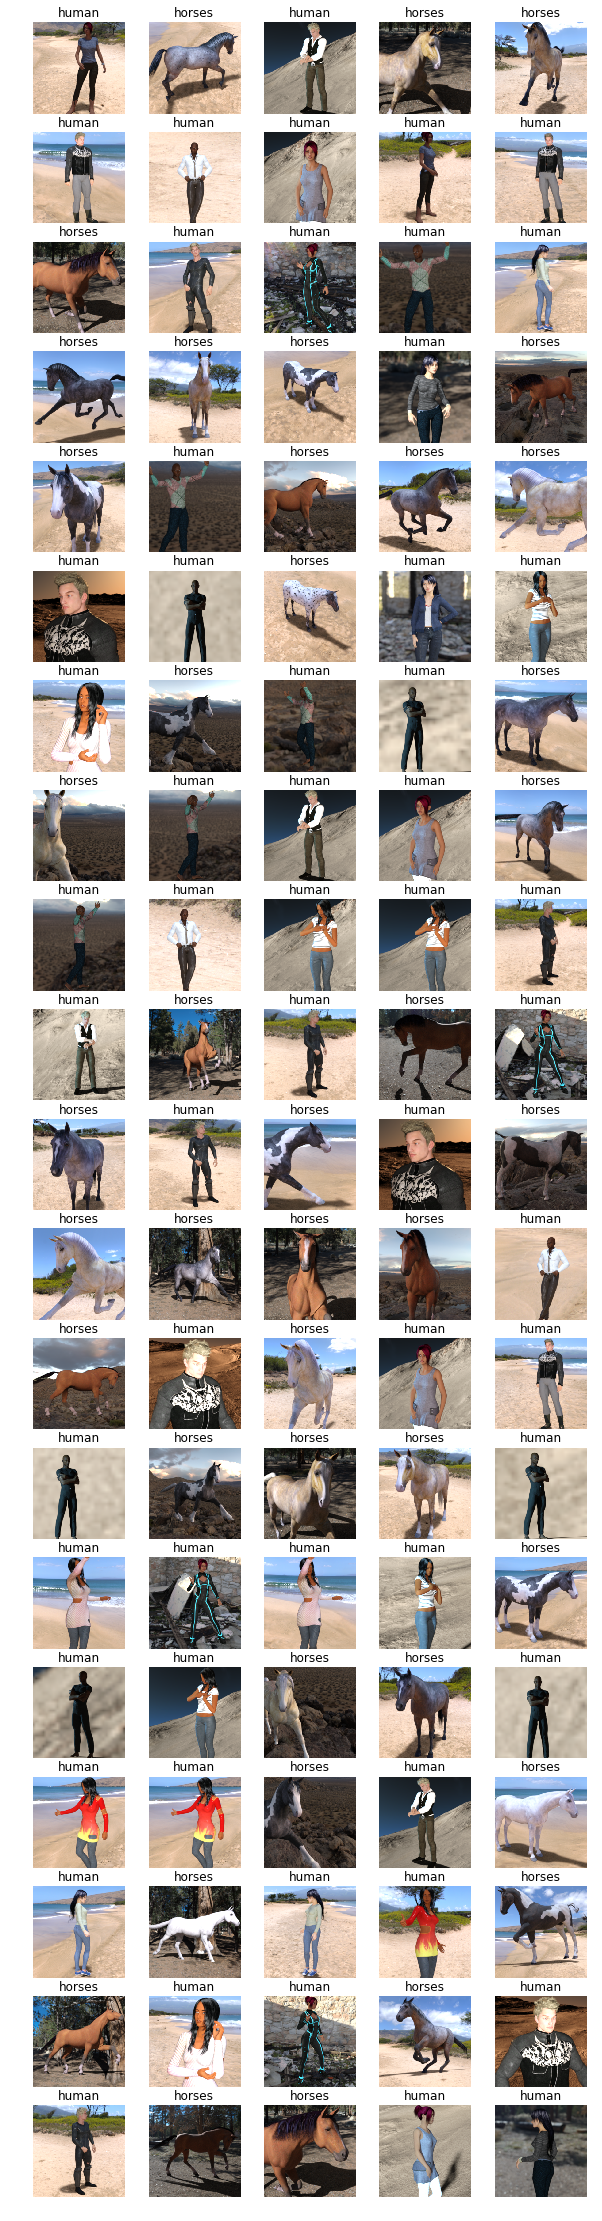

In [0]:
n_plot = 100
class_names = np.array(['horses', 'human'])

plt.figure(figsize=(10,(n_plot+4)//5*2))
for i in range(n_plot):
  plt.subplot((n_plot+4)//5,5,i+1)
  plt.imshow(x_train[i])
  plt.title(class_names[y_train[i]])
  plt.axis('off')

We build 3 models.

1.   The 1st model is a standard CNN with 3 layers. (accuracy ~ 80% to 85%)
2.   The 2nd model is based on the mobilenet model imported from tfhub. (accuracy ~ 99%) https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
3.   The 3rd model is based on the inception model imported from tfhub. (accuracy ~ 97%) https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4



In [0]:
def cnn_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(16, padding = 'same', kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(im_res, im_res, 3)))
  model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))
  model.add(tf.keras.layers.Conv2D(32, padding = 'same', kernel_size=(3, 3), activation=tf.nn.relu))
  model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))
  model.add(tf.keras.layers.Conv2D(64, padding = 'same', kernel_size=(3, 3), activation=tf.nn.relu))
  model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
  
  return model

In [0]:
def mobilenet_v2():
  model = tf.keras.Sequential()
  model.add(hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                           trainable=False, input_shape=(224, 224, 3)))
  model.add(tf.keras.layers.Dense(n_class, activation='softmax'))
  
  return model

In [0]:
def inception_v3():
  model = tf.keras.Sequential()
  model.add(hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4",
                           trainable=False, input_shape=(299, 299, 3)))
  model.add(tf.keras.layers.Dense(n_class, activation='softmax'))
  
  return model

In [0]:
def im_array_resize(array, res):
  n_image = array.shape[0]
  new_array = np.empty((n_image, res, res, 3))
  for i in range(n_image):
    new_array[i] = tf.image.resize(array[i], (res, res))/255.0
  return new_array

Try uncommenting the codes to try different models.

In [0]:
## conventional CNN, up to 85% accuracy.
# x_train = im_array_resize(x_train, im_res)
# x_test = im_array_resize(x_test, im_res)
# model = cnn_model()

## mobilnet, over 99% accuracy.
# x_train = im_array_resize(x_train, 224)
# x_test = im_array_resize(x_test, 224)
# model = mobilenet_v2()

## inception, almost 100% accuracy.
x_train = im_array_resize(x_train, 299)
x_test = im_array_resize(x_test, 299)
model = inception_v3()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
epochs = 10
batch_size = 16

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train,
                   batch_size=batch_size, epochs=epochs,
                   validation_data=(x_test, y_test))

Train on 1027 samples, validate on 256 samples
Epoch 1/10
1027/1027 [==============================] - 27s 26ms/sample - loss: 0.0919 - accuracy: 0.9757 - val_loss: 0.0393 - val_accuracy: 0.9961
Epoch 2/10
1027/1027 [==============================] - 14s 14ms/sample - loss: 0.0088 - accuracy: 0.9990 - val_loss: 0.0219 - val_accuracy: 0.9961
Epoch 3/10
1027/1027 [==============================] - 14s 14ms/sample - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 0.9961
Epoch 4/10
1027/1027 [==============================] - 14s 14ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 0.9961
Epoch 5/10
1027/1027 [==============================] - 14s 14ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 0.9961
Epoch 6/10
1027/1027 [==============================] - 14s 14ms/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 7/10
1027/1027 [==============================] - 14s 14ms/

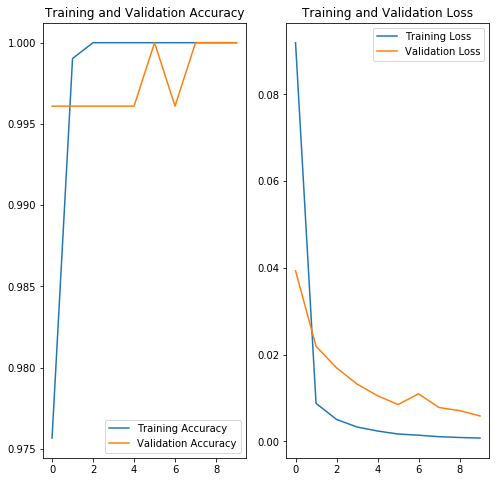

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['loss'], label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

A visualization of the first 100 pictures in the test data. The blue labels are correct and the red labels are incorrect.

Running Mobilnet or Inception, we usually get over 99% validation accuracy and no red labels.

Running a conventional CNN, we get validation accuracy of up to 85%. The red labels are usually the horses mislabelled as human.

In [0]:
y_pred = np.argmax(model.predict(x_test[:n_plot]),axis=-1)
y_pred

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

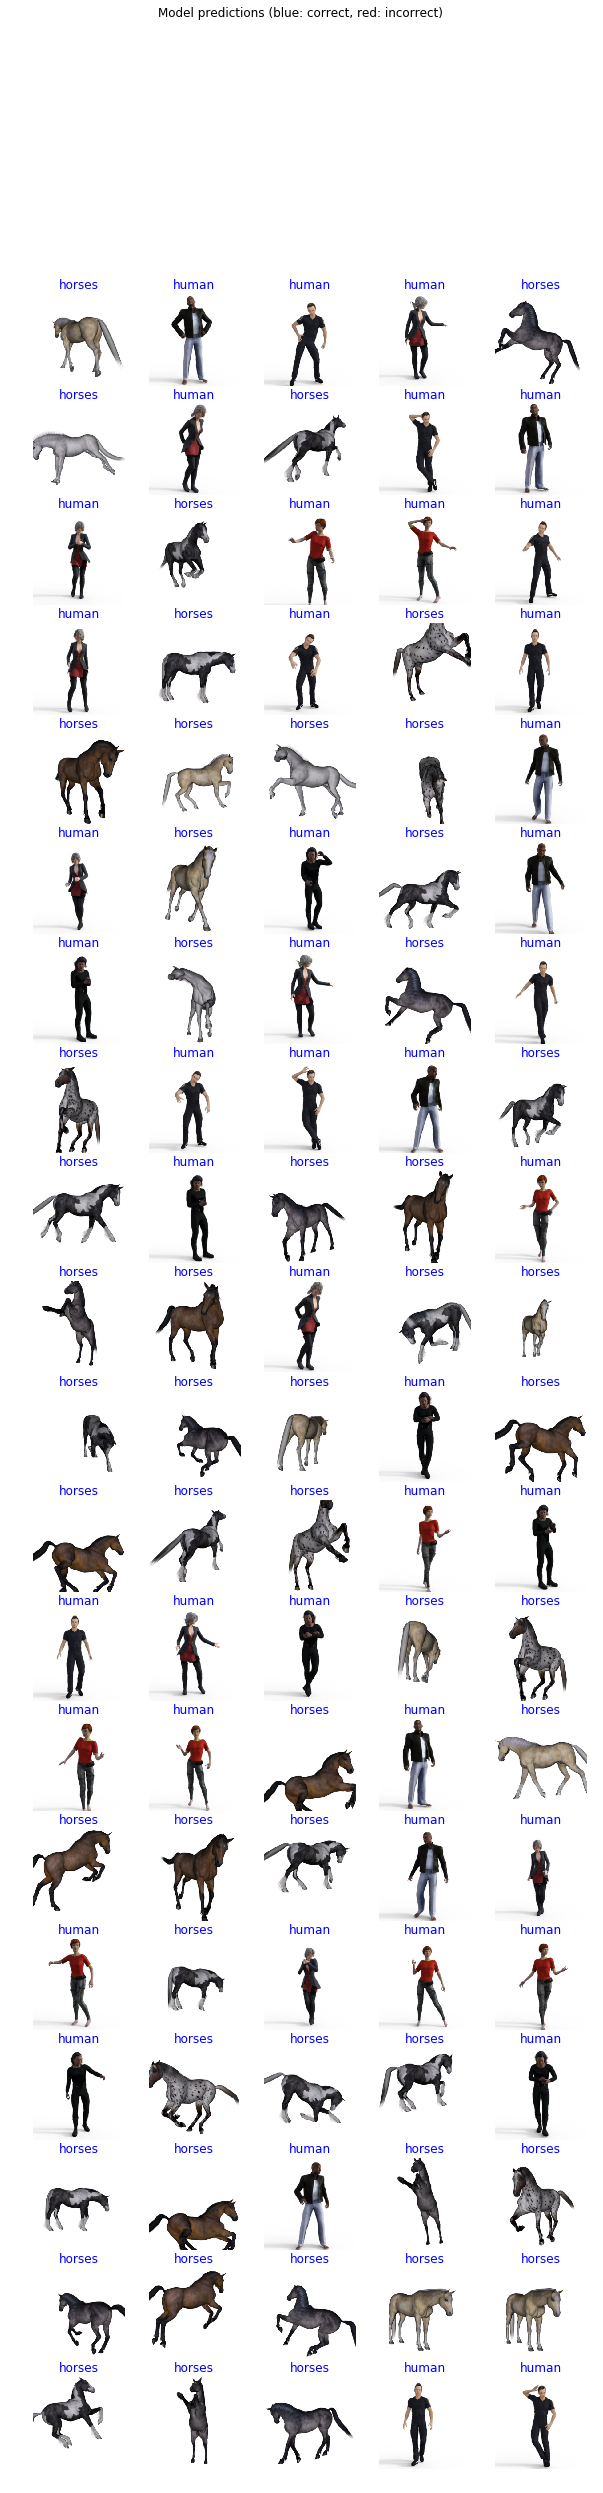

In [0]:
plt.figure(figsize=(10,(n_plot+4)//5*2))
for i in range(n_plot):
  plt.subplot((n_plot+4)//5,5,i+1)
  plt.imshow(x_test[i])
  color = "blue" if y_pred[i] == y_test[i] else "red"
  plt.title(class_names[y_pred[i]], color=color)
  plt.axis('off')
  plt.suptitle("Model predictions (blue: correct, red: incorrect)")